# Module 1 - Data Load / Display / Normalization

In this module you will learn how to load a nifti image utilizing  nibabel and create datasets that can be used with machine learning algorithms. The basic features we will consider are intensity based and originate from multiple acquisition types. 

### Step 1: Load basic python libraries 

In [1]:
%matplotlib inline
import os 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import csv
from pandas.tools.plotting import scatter_matrix
from sklearn import preprocessing
import nibabel as nib

/Users/mri3977/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Step 2: Load the three types of images available. 

- T1w pre-contrast
- FLAIR 
- T1w post-contrast 

The goal is to  create a 4D image that contains all four 3D volumes we will use in our example

In [2]:
CurrentDir= os.getcwd()

# Print current directory
print (CurrentDir)

# Get parent direcotry 
print(os.path.abspath(os.path.join(CurrentDir, os.pardir)))

# Create the file paths. The images are contained in a subfolder called Data. 
PostName =  os.path.abspath(os.path.join(os.path.abspath(os.path.join(CurrentDir, os.pardir)), "Data",  'POST.nii.gz')  )
PreName =  os.path.abspath(os.path.join(os.path.abspath(os.path.join(CurrentDir, os.pardir)), "Data", 'PRE.nii.gz') )
FLAIRName =  os.path.abspath(os.path.join(os.path.abspath(os.path.join(CurrentDir, os.pardir)), "Data", 'FLAIR.nii.gz') )
GroundTruth=  os.path.abspath(os.path.join(os.path.abspath(os.path.join(CurrentDir, os.pardir)), "Data", 'GroundTruth.nii.gz') )


# read Pre in--we assume that all images are same x,y dims
Pre = nib.load(PreName)
# Pre is a class containing the image data among other information 
Pre=Pre.get_data()
xdim = np.shape(Pre)[0]
ydim = np.shape(Pre)[1]
zdim = np.shape(Pre)[2]
# Printing the dimensions of an image 
print ('Dimensions')
print (xdim,ydim,zdim)
# make space in a numpy array for the images
ArrayDicom = np.zeros((xdim, ydim,zdim, 4), dtype=Pre.dtype)
# copy Pre pixels into z=0
ArrayDicom[:, :, :, 0] = Pre
# Post
Post = nib.load(PostName)
# Pre is a class containing the image data among other information 
Post=Post.get_data()
ArrayDicom[:, :, :, 1] = Post
#FLAIR
Flair = nib.load(FLAIRName)
# Pre is a class containing the image data among other information 
Flair=Flair.get_data()
ArrayDicom[:, :, :, 2] = Flair  
print ("Data Loaded")

/Users/mri3977/Repos/MachineLearningForMedicalImages/notebooks
/Users/mri3977/Repos/MachineLearningForMedicalImages
Dimensions
(240, 240, 155)
Data Loaded


### Create traing set

We assume the following labels. 

> Enhancing Tumor = 4

> Edema = 2

> WM and CSF and GM=1

> Background (air) = 0
    

In [3]:
#  Load Ground Truth
GroundTrutha = nib.load(GroundTruth)
GroundTruth=GroundTrutha.get_data()
print ("Data Loaded")

Data Loaded


#### Plot the images 

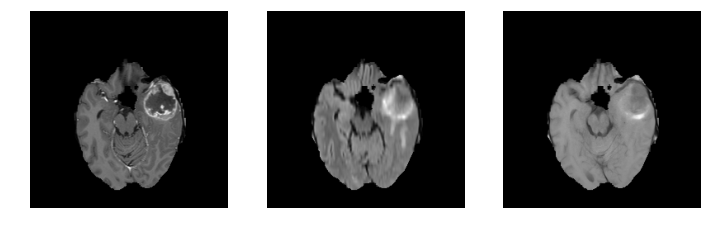

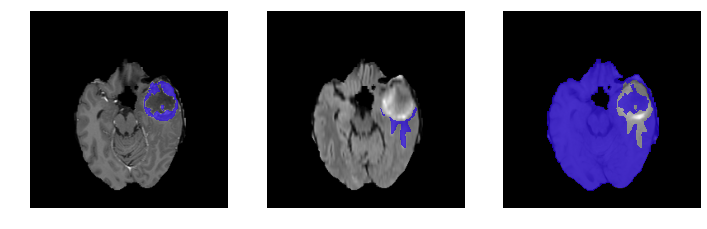

In [18]:
sl = 55 #slice to visualize

# Construct figure showing individual slices for post, flair, and pre sequences
f, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,12))
ax1.imshow(np.rot90(Post[:, :, sl],3), cmap=plt.cm.gray)
ax1.axis('off')
ax2.imshow(np.rot90(Flair[:, :, sl],3), cmap=plt.cm.gray)
ax2.axis('off')
ax3.imshow(np.rot90(Pre[:, :, sl],3), cmap=plt.cm.gray)
ax3.axis('off')
plt.show()

# Construct figure including segmentation overlays
f, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,12))
ax1.imshow(np.rot90(Post[:, :, sl],3), cmap=plt.cm.gray)
seg = np.rot90(GroundTruth[:,:,sl]==4,3) #Enhancing tumor
seg = np.ma.masked_where(seg==0,seg)
ax1.imshow(seg, cmap=plt.cm.brg, alpha = 0.7, vmin=0.7, vmax = 5, interpolation = 'nearest')
ax1.axis('off')
ax2.imshow(np.rot90(Flair[:, :, sl],3), cmap=plt.cm.gray)
seg = np.rot90(GroundTruth[:,:,sl]==2,3) #Edema
seg = np.ma.masked_where(seg==0,seg)
ax2.imshow(seg, cmap=plt.cm.brg, alpha = 0.7, vmin=0.7, vmax = 5, interpolation = 'nearest')
ax2.axis('off')
ax3.imshow(np.rot90(Pre[:, :, sl],3), cmap=plt.cm.gray)
seg = np.rot90(GroundTruth[:,:,sl]==1,3) #WM, CSF, and GM
seg = np.ma.masked_where(seg==0,seg)
ax3.imshow(seg, cmap=plt.cm.brg, alpha = 0.7, vmin=0.7, vmax = 5, interpolation = 'nearest')
ax3.axis('off')
plt.show()
 

### Create dataset

In [20]:
# Create classes
# Tissue =GM+CSG+WM
ClassTissuePost=(Post[np.nonzero(GroundTruth==1)])
ClassTissuePre=(Pre[np.nonzero(GroundTruth==1)])
ClassTissueFlair=(Flair[np.nonzero(GroundTruth==1)])
# Enhancing Tumor 
ClassTumorPost=(Post[np.nonzero(GroundTruth==4)])
ClassTumorPre=(Pre[np.nonzero(GroundTruth==4)])
ClassTumorFlair=(Flair[np.nonzero(GroundTruth==4)])
# Edema 
ClassEdemaPost=(Post[np.nonzero(GroundTruth==2)])
ClassEdemaPre=(Pre[np.nonzero(GroundTruth==2)])
ClassEdemaFlair=(Flair[np.nonzero(GroundTruth==2)])

# We only select 1000 points for demonstration purposes
IND=np.random.randint(np.shape(ClassTumorPre)[0], size=1000)
ClassTissuePost=ClassTissuePost[IND]
ClassTissuePre=ClassTissuePre[IND]
ClassTissueFlair=ClassTissueFlair[IND]
ClassTumorPost=ClassTumorPost[IND]
ClassTumorPre=ClassTumorPre[IND]
ClassTumorFlair=ClassTumorFlair[IND]
ClassEdemaPost=ClassEdemaPost[IND]
ClassEdemaPre=ClassEdemaPre[IND]
ClassEdemaFlair=ClassEdemaFlair[IND]

# Normalize zero mean unit standard deviation
ClassTissuePost= preprocessing.scale(ClassTissuePost)
ClassTissuePre= preprocessing.scale(ClassTissuePre)
ClassTissueFlair= preprocessing.scale(ClassTissueFlair)
ClassTumorPost= preprocessing.scale(ClassTumorPost)
ClassTumorPre= preprocessing.scale(ClassTumorPre)
ClassTumorFlair= preprocessing.scale(ClassTumorFlair)
ClassEdemaPost= preprocessing.scale(ClassEdemaPost)
ClassEdemaPre= preprocessing.scale(ClassEdemaPre)
ClassEdemaFlair= preprocessing.scale(ClassEdemaFlair)

# Save the data to CSV using pandas
print ("Saving the data to a pandas dataframe and subsequently to a csv")
# Create a dictionary containing the classes
datasetcomplete={"ClassTissuePost": ClassTissuePost, "ClassTissuePre": ClassTissuePre, "ClassTissueFlair": ClassTissueFlair, "ClassTumorPost": ClassTumorPost, "ClassTumorPre": ClassTumorPre, "ClassTumorFlair": ClassTumorFlair, "ClassEdemaPost": ClassEdemaPost, "ClassEdemaPre": ClassEdemaPre, "ClassEdemaFlair": ClassEdemaFlair}

datapd=pd.DataFrame.from_dict(datasetcomplete,orient="index")
# print (datapd)
datapd=datapd.transpose()
# datapd=pd.DataFrame(dict([ (k,Series(v)) for k,v in datasetcomplete.iteritems() ]))
datapd.to_csv("DataExample.csv",index=False)

Saving the data to a pandas dataframe and subsequently to a csv


### Create some scatter plots

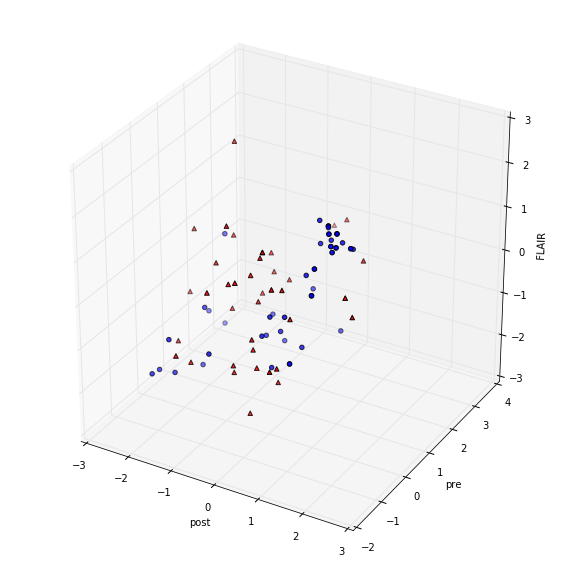

In [25]:
# Display Tumor vs NAWM
IND=np.random.randint(100, size=50)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ClassTissuePost[IND,], ClassTissuePre[IND,], ClassTissueFlair[IND,])
ax.scatter(ClassTumorPost[IND,], ClassTumorPre[IND,], ClassTumorFlair[IND,], c='r', marker='^')
ax.set_xlabel('post')
ax.set_ylabel('pre')
ax.set_zlabel('FLAIR')
plt.show()

## Describe the data 

In [24]:
# descriptions
print(datapd.describe())

       ClassEdemaPre  ClassEdemaPost  ClassTissueFlair  ClassEdemaFlair  \
count   1.000000e+03    1.000000e+03      1.000000e+03     1.000000e+03   
mean    9.994954e-09   -1.341000e-08     -1.750933e-08     1.011501e-08   
std     1.000500e+00    1.000500e+00      1.000500e+00     1.000500e+00   
min    -5.677559e+00   -6.491440e+00     -1.377073e+00    -3.660893e+00   
25%    -6.582602e-01   -7.044311e-01     -9.637672e-01    -7.927794e-01   
50%     6.911432e-02    6.895627e-02     -1.937224e-01     9.643344e-02   
75%     7.142150e-01    6.018094e-01      1.048742e+00     8.474142e-01   
max     4.836244e+00    4.114276e+00      2.205756e+00     2.018237e+00   

       ClassTumorFlair  ClassTissuePost  ClassTumorPost  ClassTissuePre  \
count     1.000000e+03     1.000000e+03    1.000000e+03    1.000000e+03   
mean      2.362765e-09    -7.445342e-09   -7.410476e-09    4.601665e-09   
std       1.000500e+00     1.000500e+00    1.000500e+00    1.000500e+00   
min      -3.351960e+00  